In [0]:
# !/databricks/python3/bin/python -m pip install --upgrade pip
!pip install torch
!pip install pandas 

You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.


In [0]:
import pandas as pd 
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np 
import torch
from torch.utils.data import DataLoader, TensorDataset
import math


n_past = 10
n_future = 1

batch_size = 50 




# data loading processes 
df = spark.read.option("header","true").option("inferSchema","true").csv("s3://f22cs6350/weatherHistory.csv") 
df = df.toPandas()
# removing null and creating in categorical values 
df = df.dropna()
cat = pd.get_dummies(df['Precip Type'])
df['rain'] = cat['rain']
df['snow'] = cat['snow']

# removing time and utc from Formatted Date col and grouping by the date 
temp_main=df[['Formatted Date','Temperature (C)','Apparent Temperature (C)','Humidity','Visibility (km)']]
temp_label = df[['Formatted Date','rain','snow']]


temp_df = []
for i in range(len(temp_main['Formatted Date'])):
    temp_df.append(str(temp_main['Formatted Date'][i].date()))

temp_main['Formatted Date'] = temp_df
temp_main = temp_main.groupby('Formatted Date').mean()

temp_df = []
for i in range(len(temp_label['Formatted Date'])):
    temp_df.append(str(temp_label['Formatted Date'][i].date()))

temp_label['Formatted Date'] = temp_df
temp_label = temp_label.groupby('Formatted Date').median()


# normaalizing the data 
temp_main = (temp_main - temp_main.mean()) / temp_main.std()

temp = temp_main

temp['rain'],temp['snow'] = temp_label['rain'],temp_label['snow']


# creating sample and data loaders for training  
x_data = []
y_data = []
y_temp = temp['Temperature (C)']
x_temp = temp[['Apparent Temperature (C)','Humidity','Visibility (km)' ,'rain','snow']]

for i in range(0,len(temp)-n_past-n_future+1):
    x_data.append(x_temp.iloc[i : i + n_past])     
    y_data.append(y_temp.iloc[i + n_past : i + n_past + n_future])    
x_data , y_data = np.array(x_data), np.array(y_data)
x_data = np.reshape(x_data, (x_data.shape[0] , x_data.shape[1],x_data.shape[2] ,1) )


## split the data in train valid and test set 
X_train, X_test, Y_train, Y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)


training_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(Y_train))  
testing_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(Y_test))  

training_loader = DataLoader(training_data, shuffle=True, batch_size=batch_size)  
testing_loader = DataLoader(testing_data, shuffle=True, batch_size=batch_size)


<command-1027499617500746>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_main['Formatted Date'] = temp_df
<command-1027499617500746>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_label['Formatted Date'] = temp_df


Out[7]: <seaborn.axisgrid.PairGrid at 0x7f4f58c86c10>

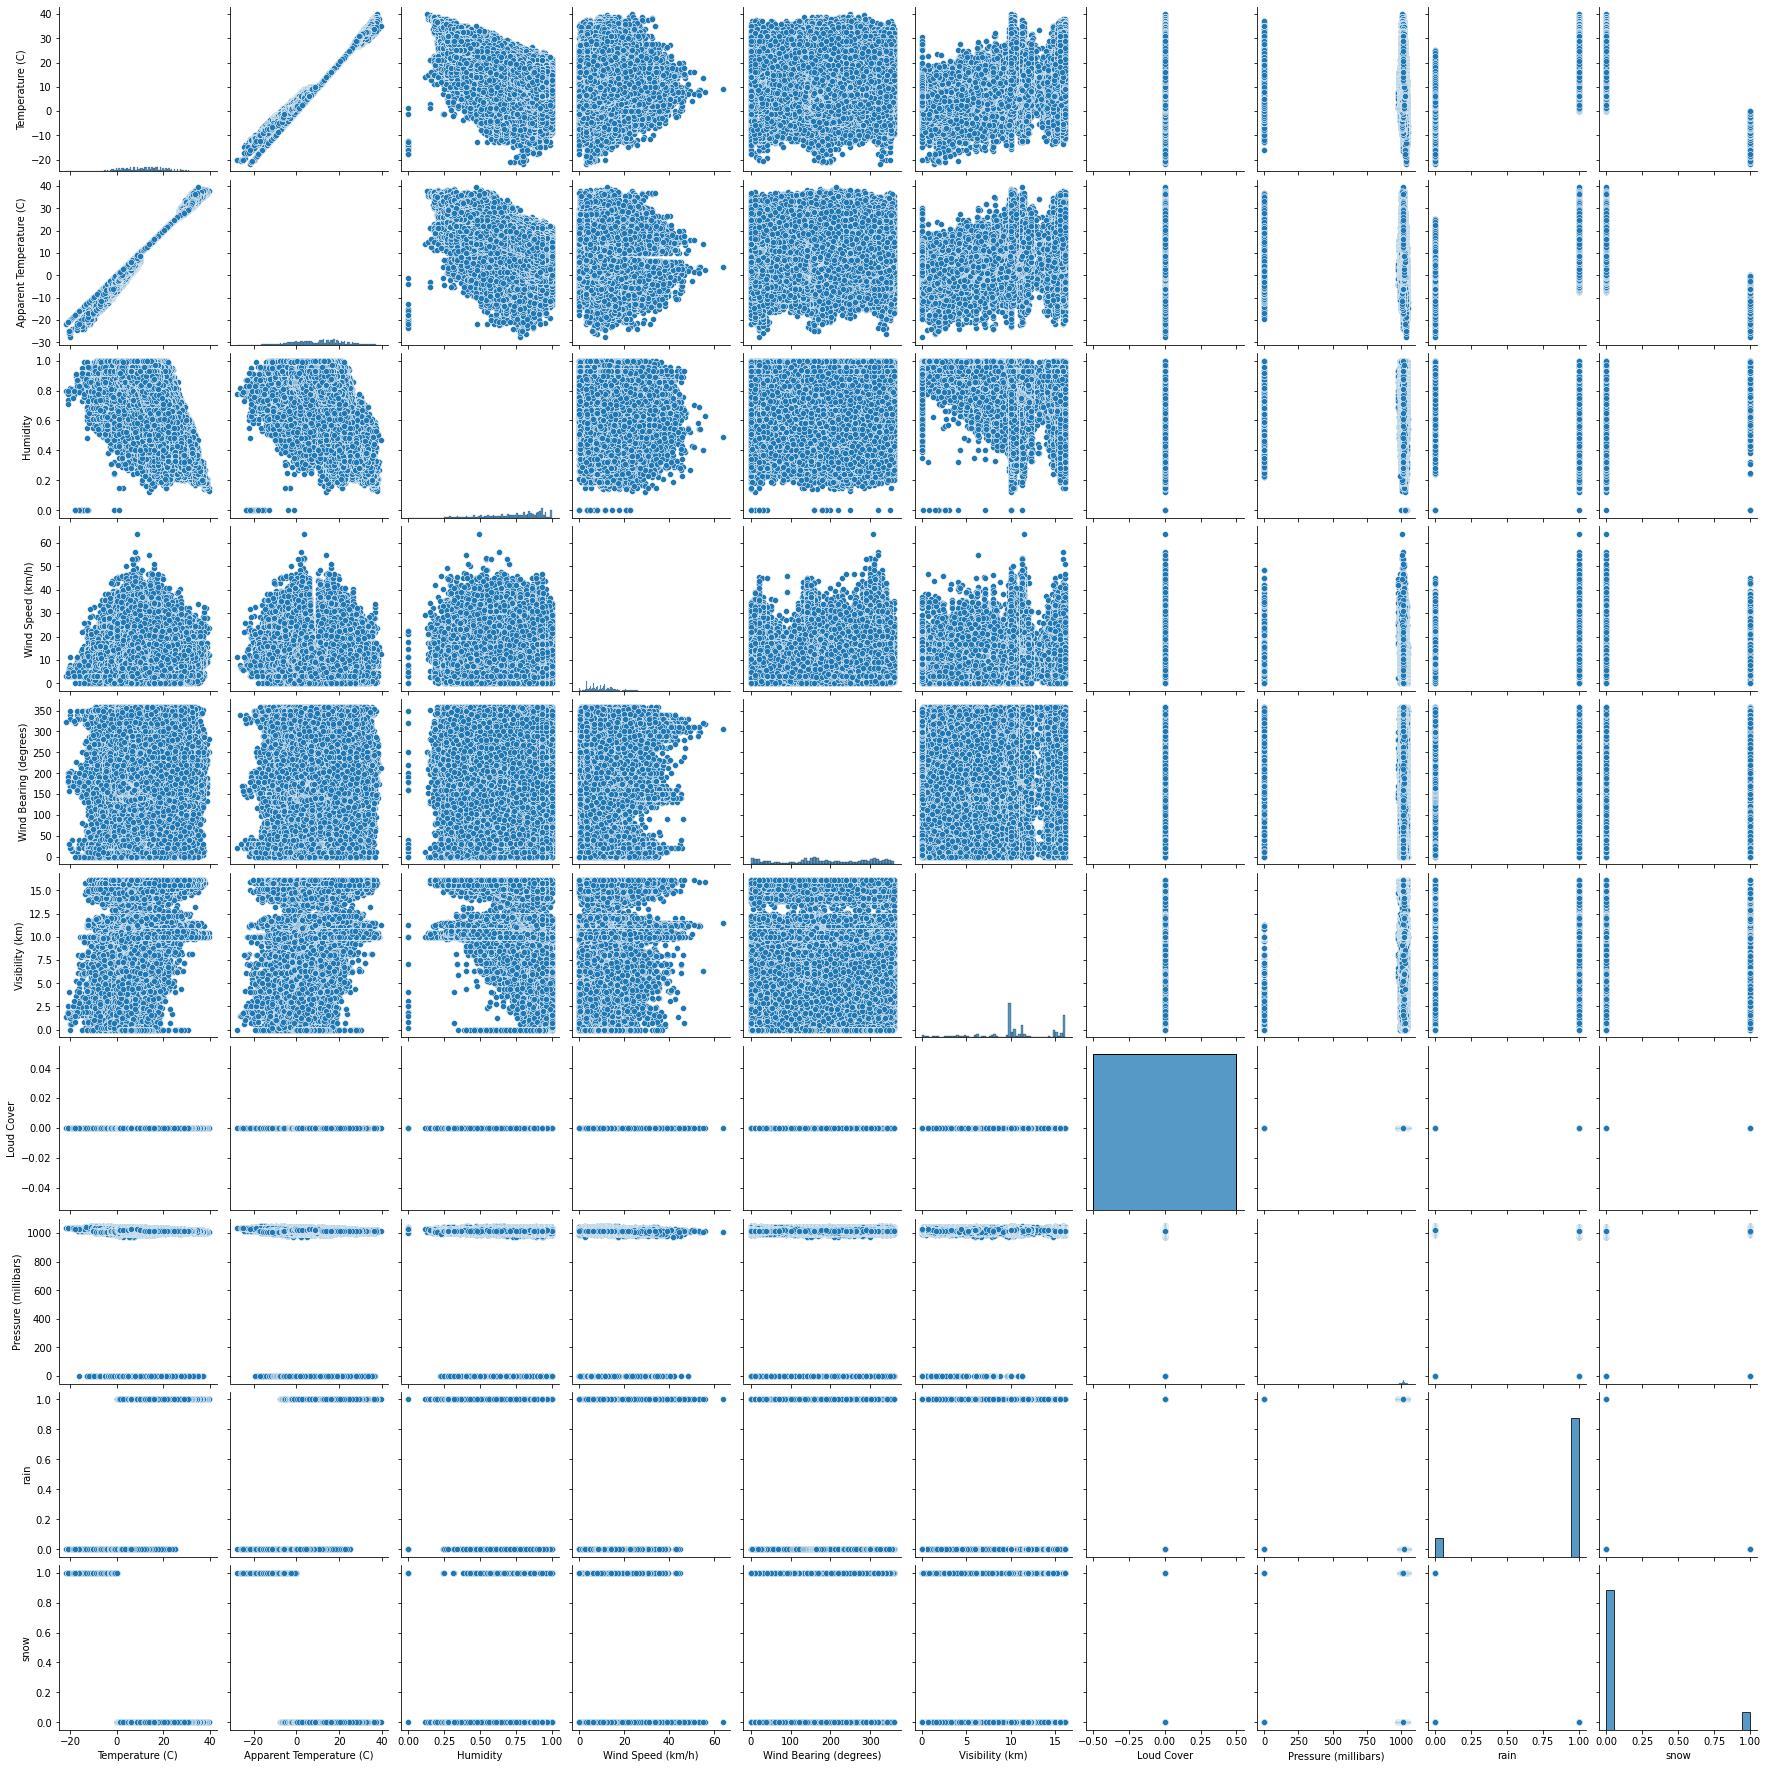

In [0]:
### All the data processing done after understanding the following plots 
sns.pairplot(df)

Out[8]: <AxesSubplot:>

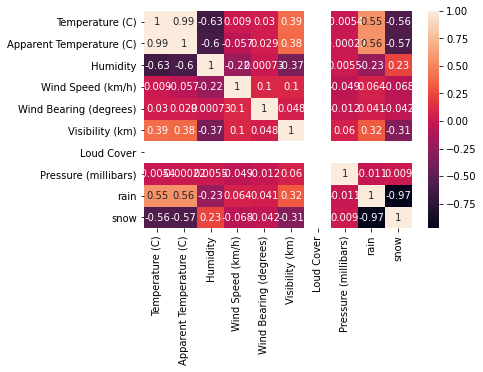

In [0]:
sns.heatmap(df.corr(),annot=True)

Out[9]: <AxesSubplot:>

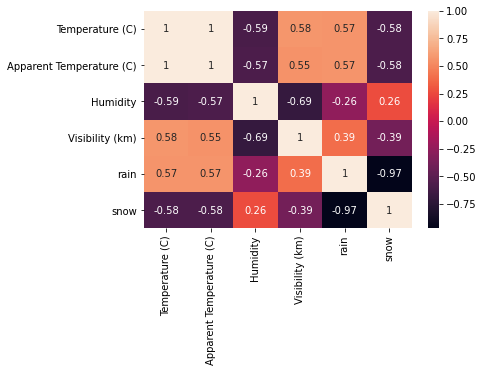

In [0]:
sns.heatmap(temp_main.corr(),annot=True)

<command-1027499617500750>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp11['Formatted Date'] = temp_df
Out[10]: <AxesSubplot:xlabel='Formatted Date', ylabel='Temperature (C)'>

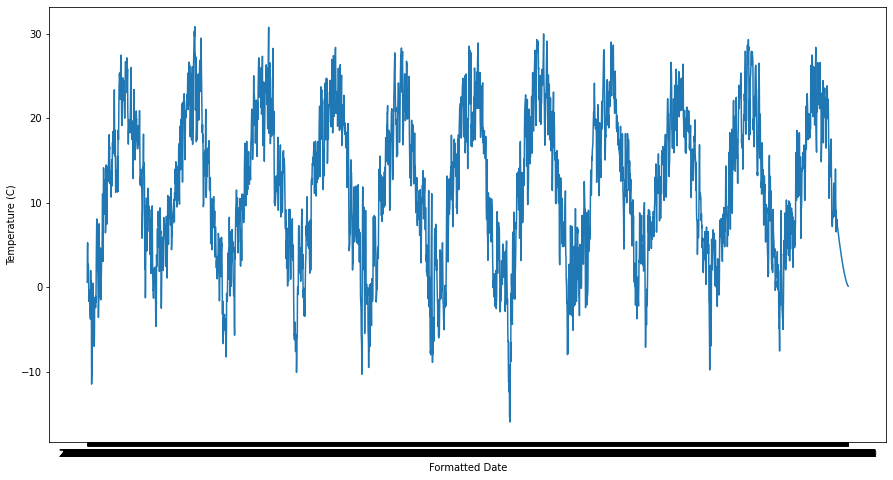

In [0]:
import matplotlib.pyplot as plt

temp11=df[['Formatted Date','Temperature (C)','Apparent Temperature (C)','Humidity','Visibility (km)']] # ,'rain','snow']]

# temp_df11 = temp11['Formatted Date'].str.split(expand=True)
# temp11['Formatted Date'] = temp_df11[0]
# temp_plot11 = temp11.groupby('Formatted Date',as_index=False).mean()

temp_df = []
for i in range(len(temp11['Formatted Date'])):
    temp_df.append(str(temp11['Formatted Date'][i].date()))

temp11['Formatted Date'] = temp_df
temp_plot11 = temp11.groupby('Formatted Date').mean()

#temp_plot11["Formatted Date"] = pd.to_datetime(temp_plot11["Formatted Date"], format = "%Y-%m-%d")

plt.figure(figsize = (15,8))
sns.lineplot(x = "Formatted Date", y = "Temperature (C)",data = temp_plot11)

Out[11]: <AxesSubplot:xlabel='Formatted Date', ylabel='Humidity'>

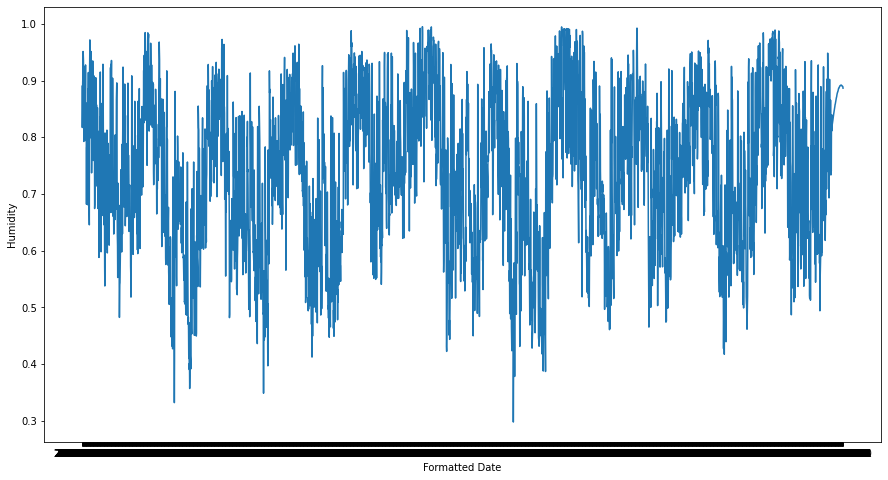

In [0]:
plt.figure(figsize = (15,8))
sns.lineplot(x = "Formatted Date", y = "Humidity",data = temp_plot11)

Out[12]: <AxesSubplot:xlabel='Formatted Date', ylabel='Visibility (km)'>

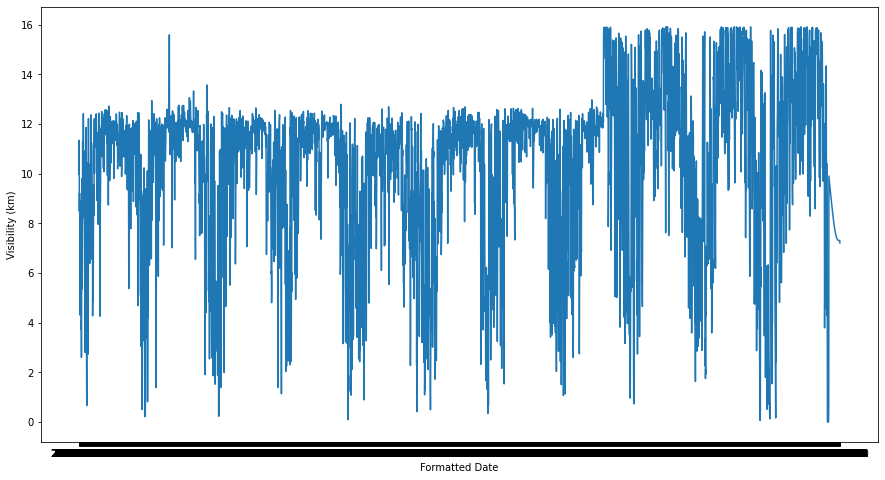

In [0]:
plt.figure(figsize = (15,8))
sns.lineplot(x = "Formatted Date", y = "Visibility (km)",data = temp_plot11)

In [0]:
# LSTM (1 LSTM Layer, 1 Linear Output Layer)

# Equations Source: https://codeburst.io/generating-text-using-an-lstm-network-no-libraries-2dff88a3968

class LSTM:
    
    # Weight and bias Initializations
    def __init__(self, hidden_size, num_features, num_timesteps, output_size = 1):
        
#         self.x = []
        self.hidden_size = hidden_size
        self.num_features = num_features
        self.num_timesteps = num_timesteps
        self.output_size = output_size
        
        # Forget gate weights
        self.W_f = self.xavier_initialization((hidden_size, num_features))
        self.U_f = self.xavier_initialization((hidden_size,hidden_size))
        self.b_f = np.zeros((hidden_size, 1))

        # Input gate weights
        self.W_i = self.xavier_initialization((hidden_size, num_features))
        self.U_i = self.xavier_initialization((hidden_size,hidden_size))
        self.b_i = np.zeros((hidden_size, 1))

        # Candidate Cell state weights
        self.W_cnd = self.xavier_initialization((hidden_size, num_features))
        self.U_cnd = self.xavier_initialization((hidden_size,hidden_size))
        self.b_cnd = np.zeros((hidden_size, 1))

        # Output gate weights
        self.W_o = self.xavier_initialization((hidden_size, num_features))
        self.U_o = self.xavier_initialization((hidden_size,hidden_size))
        self.b_o = np.zeros((hidden_size, 1))

        # Output layer weights
        self.V = self.xavier_initialization((output_size, hidden_size))
        self.b = np.zeros((output_size, 1))

        # Cell state storage and hidden state storage
        self.c_states = np.zeros((self.num_timesteps + 1, self.hidden_size, 1))

        # Hidden state storage
        self.h_states = np.zeros((self.num_timesteps + 1, self.hidden_size, 1))

        # Output gate storage
        self.o_states = np.zeros((self.num_timesteps + 1, self.hidden_size, 1))

        # Forget gate storage
        self.f_states = np.zeros((self.num_timesteps + 1, self.hidden_size, 1))

        # Input gate storage
        self.i_states = np.zeros((self.num_timesteps + 1, self.hidden_size, 1))

        # Candidate gate storage
        self.cnd_states = np.zeros((self.num_timesteps + 1, self.hidden_size, 1))
        

    # Xavier initialization
    def xavier_initialization(self, shape):
        xavier_scale = np.sqrt(2/(shape[0] + shape[1]));
        return np.random.normal(0.0, xavier_scale, shape);
    
    # Forward Propagation, x.shape = (num_timesteps, num_features, 1)
    def forward(self, x):

        # Store x for backpropagation
        self.x = x 

        hprev = np.zeros((self.hidden_size, 1))
        cprev = np.zeros((self.hidden_size, 1))

        # For each timestep do h(t) = tanh(W.x(t) + U.h(t-1))
        for t in range(1, self.num_timesteps+1):
            
            # Input gate: i(t) = sigmoid(W_i @ x(t) + U_i @ h(t-1) + b_i)
            i = self.sigmoid(self.W_i @ x[t-1] + self.U_i @ self.h_states[t-1] + self.b_i)
            self.i_states[t] = i

            # Forget gate: f(t) = sigmoid(W_f @ x(t) + U_f @ h(t-1) + b_f)
            f = self.sigmoid(self.W_f @ x[t-1] + self.U_f @ self.h_states[t-1] + self.b_f)
            self.f_states[t] = f

            # Output gate: o(t) = sigmoid(W_o @ x(t) + U_o @ h(t-1) + b_o)
            o = self.sigmoid(self.W_o @ x[t-1] + self.U_o @ self.h_states[t-1] + self.b_o)
            self.o_states[t] = o

            # Candidate states: cnd(t) = tanh(W_cnd @ x(t) + U_cnd @ h(t-1) + b_cnd)
            cnd = np.tanh(self.W_cnd @ x[t-1] + self.U_cnd @ self.h_states[t-1])
            self.cnd_states[t] = cnd

            # Current cell state: C(t) = (f(t) * C(t-1)) + (i(t) * cnd(t))
            self.c_states[t] = (f * self.c_states[t-1]) + (i * cnd)

            # Hidden state: h(t) = o(t) * tanh(C(t))
            self.h_states[t] = o * np.tanh(self.c_states[t])

        # After last timestep apply linear activation since we are doing single variable regression
        y_hat = self.V @ self.h_states[self.num_timesteps]
        return self.i_states,self.f_states,self.o_states,self.cnd_states,self.c_states,self.h_states,y_hat

    def backward(self,x, y_true, y_hat,i_states,f_states,o_states,cnd_states,c_states,h_states):
        self.x = x
        self.i_states,self.f_states,self.o_states,self.cnd_states,self.c_states,self.h_states = i_states,f_states,o_states,cnd_states,c_states,h_states
        dc_next = np.zeros((self.hidden_size, 1))
        dh_next = np.zeros((self.hidden_size, 1))
        di_next = np.zeros((self.hidden_size, 1))
        df_next = np.zeros((self.hidden_size, 1))
        do_next = np.zeros((self.hidden_size, 1))
        dcnd_next = np.zeros((self.hidden_size, 1))
        f_next = np.zeros((self.hidden_size, 1))

        dW_i_sum = np.zeros(self.W_i.shape)
        dU_i_sum = np.zeros(self.U_i.shape)
        db_i_sum = np.zeros(self.b_i.shape)
        
        dW_f_sum = np.zeros(self.W_f.shape)
        dU_f_sum = np.zeros(self.U_f.shape)
        db_f_sum = np.zeros(self.b_f.shape)
        
        dW_o_sum = np.zeros(self.W_o.shape)
        dU_o_sum = np.zeros(self.U_o.shape)
        db_o_sum = np.zeros(self.b_o.shape)

        dW_cnd_sum = np.zeros(self.W_cnd.shape)
        dU_cnd_sum = np.zeros(self.U_cnd.shape)
        db_cnd_sum = np.zeros(self.b_cnd.shape)

        # dX ~= dL/dX
        # weight updates for output layer
        dY = (y_true - y_hat)
        dV = dY * self.h_states[self.num_timesteps].T
        db = dY

        # Internal weight updates
        for t in reversed(range(1, self.num_timesteps + 1)):
            
            # dL/dY * dY/dh(t) + grads from next hidden state
            dh_i_grad = self.U_i @ di_next
            dh_f_grad = self.U_f @ df_next
            dh_o_grad = self.U_o @ do_next
            dh_cnd_grad = self.U_cnd @ dcnd_next

            dh_t = (self.V.T @ dY) + dh_i_grad + dh_f_grad + dh_o_grad + dh_cnd_grad

            # dL/do(t) = dL/dh(t) * dh(t)/do(t)
            do = dh_t * np.tanh(self.c_states[t])

            # dL/dC(t) = dL/dh(t) * dh(t)/dC(t) + grads from next cell state
            dC_t = dh_t * self.o_states[t] * (1 - (np.tanh(self.c_states[t]) ** 2)) + (f_next * dc_next)
            dc_next = dC_t
            f_next = self.f_states[t]

            # dL/df(t) = dL/dC(t) * dC(t)/df(t)
            df = dC_t * self.c_states[t-1]

            # dL/di(t) = dL/dC(t) * dC(t)/di(t)
            di = dC_t * self.cnd_states[t]

            # dL/dcnd(t) = dL/dC(t) * dC(t)/dcnd(t)
            dcnd = dC_t * self.i_states[t]

            # dL/dW_i = dL/di(t) * di(t)/dW_i
            # dL/dU_i = dL/di(t) * di(t)/dU_i
            # dL/db_i = dL/di(t) * di(t)/db_i
            dW_i = (di * self.i_states[t] * (1 - self.i_states[t])) @ self.x[t-1].T
            dU_i = (di * self.i_states[t] * (1 - self.i_states[t])) @ self.h_states[t-1].T
            db_i = (di * self.i_states[t] * (1 - self.i_states[t]))
            di_next = db_i

            # dL/dW_f = dL/df(t) * df(t)/dW_f
            # dL/dU_f = dL/df(t) * df(t)/dU_f
            # dL/db_f = dL/df(t) * df(t)/db_f
            dW_f = (df * self.f_states[t] * (1 - self.f_states[t])) @ self.x[t-1].T
            dU_f = (df * self.f_states[t] * (1 - self.f_states[t])) @ self.h_states[t-1].T
            db_f = (df * self.f_states[t] * (1 - self.f_states[t]))
            df_next = db_f

            # dL/dW_o = dL/do(t) * do(t)/dW_o
            # dL/dU_o = dL/do(t) * do(t)/dU_o
            # dL/db_o = dL/do(t) * do(t)/db_o
            dW_o = (do * self.o_states[t] * (1 - self.o_states[t])) @ self.x[t-1].T
            dU_o = (do * self.o_states[t] * (1 - self.o_states[t])) @ self.h_states[t-1].T
            db_o = (do * self.o_states[t] * (1 - self.o_states[t]))
            do_next = db_o

            # dL/dW_cnd = dL/dcnd(t) * dcnd(t)/dW_i
            # dL/dU_cnd = dL/dcnd(t) * dcnd(t)/dU_i
            # dL/db_cnd = dL/dcnd(t) * dcnd(t)/db_i
            
            dW_cnd = (dcnd * (1 - (self.cnd_states[t] ** 2))) @ self.x[t-1].T
            dU_cnd = (dcnd * (1 - (self.cnd_states[t] ** 2))) @ self.h_states[t-1].T
            db_cnd = (dcnd * (1 - (self.cnd_states[t] ** 2)))
            dcnd_next = db_cnd

            # Sum gradients over timesteps to calculate average gradients later
            
            dW_i_sum += dW_i
            dU_i_sum += dU_i
            db_i_sum += db_i

            dW_f_sum += dW_f
            dU_f_sum += dU_f
            db_f_sum += db_f

            dW_o_sum += dW_o
            dU_o_sum += dU_o
            db_o_sum += db_o

            
            dW_cnd_sum += dW_cnd
            dU_cnd_sum += dU_cnd
            db_cnd_sum += db_cnd

        
        dW_i = np.clip(dW_i_sum/self.num_timesteps,-5,5)
        dU_i = np.clip(dU_i_sum/self.num_timesteps,-5,5)
        db_i = np.clip(db_i_sum/self.num_timesteps,-5,5)
        dW_f = np.clip(dW_f_sum/self.num_timesteps,-5,5)
        dU_f = np.clip(dU_f_sum/self.num_timesteps,-5,5)
        db_f = np.clip(db_f_sum/self.num_timesteps,-5,5)
        dW_o = np.clip(dW_o_sum/self.num_timesteps,-5,5)
        dU_o =  np.clip(dU_o_sum/self.num_timesteps,-5,5)
        db_o = np.clip(db_o_sum/self.num_timesteps,-5,5)
        dW_cnd = np.clip(dW_cnd_sum/self.num_timesteps,-5,5)
        dU_cnd = np.clip(dU_cnd_sum/self.num_timesteps,-5,5)
        db_cnd = np.clip(db_cnd_sum/self.num_timesteps,-5,5)
        dV = np.clip(dV,-5,5)
        db = np.clip(db,-5,5)
         
        
        return dW_i,dU_i,db_i,dW_f,dU_f,db_f,dW_o,dU_o,db_o,dW_cnd,dU_cnd,db_cnd,dV,db
    
    def sigmoid(self,x):
        return 1/(1 + np.exp(-x))

In [0]:
epoch = 10
lr = 0.001
losses =[]

In [0]:
model = LSTM(256, 5, 10, 1)
# function for mapper 
def train(model,x, y_true):
    i_states,f_states,o_states,cnd_states,c_states,h_states,y_hat = model.forward(x)
    
    print(y_hat)
    grads = model.backward(x,y_true,y_hat,i_states,f_states,o_states,cnd_states,c_states,h_states)
    return grads,y_hat

#loss function 
def MSE_loss(y_true, y_hat):
    return np.sum((y_true - y_hat) ** 2)/y_hat.shape[0]

# traing loop 
for e in range(epoch):    
    epoch_loss = 0
    cnt = 0
    for inputs,label in training_loader: 
        cnt += 1
        inputs = inputs.numpy()
        label = label.numpy()
        model.x = inputs
        
        back_y_t = tuple(zip(inputs,label))
        back_y=spark.sparkContext.parallelize(back_y_t)
        out = back_y.map(lambda x: train(model,x[0],x[1].reshape((1,1)))).collect()
        out = np.array(out)
        y_hat = out[:,1]
        grads = out[:,0]
        epoch_loss += MSE_loss(label,y_hat)
        
        updated_grads = []
        j = 0
        for i in range (len(grads[0])):
            temp = np.zeros(grads[j][i].shape)
            for j in range(len(grads)):
                
                temp = temp + grads[j][i]

            temp = temp/len(grads)
            updated_grads.append(temp)
            
        updated_grads = lr * np.array(updated_grads)  

        # updating grads 
        model.W_i -= updated_grads[0]
        model.U_i -= updated_grads[1]
        model.b_i -= updated_grads[2]

        model.W_f -= updated_grads[3]
        model.U_f -= updated_grads[4]
        model.b_f -= updated_grads[5]

        model.W_o -= updated_grads[6]
        model.U_o -= updated_grads[7]
        model.b_o -= updated_grads[8]

        model.W_cnd -= updated_grads[9]
        model.U_cnd -= updated_grads[10]
        model.b_cnd -= updated_grads[11]

        model.V -= updated_grads[12]
        model.b -= updated_grads[13]
    
    print(f'Loss for epoch {e} : {epoch_loss/cnt}')
    losses.append(epoch_loss/cnt)


<command-1027499617500755>:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array(out)
<command-1027499617500755>:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  updated_grads = lr * np.array(updated_grads)
Loss for epoch 0 : [[55.20897409]]
Loss for epoch 1 : [[54.99610361]]
Loss for epoch 2 : [[54.54644909]]
Loss for epoch 3 : [[54.39931826]]
Loss for epoch 4 : [[53.98064975]]
Loss for epoch 5 : [[53.79032473]]
Loss for epoch 6 : [[53.40729294]]
Loss for epoch 7 : [[53.18216025]]
Loss for epoch 8 : [[52.97888278]]
Loss for epoch 9 : [[5

In [0]:
losses

Out[27]: [array([[55.20897409]]),
 array([[54.99610361]]),
 array([[54.54644909]]),
 array([[54.39931826]]),
 array([[53.98064975]]),
 array([[53.79032473]]),
 array([[53.40729294]]),
 array([[53.18216025]]),
 array([[52.97888278]]),
 array([[52.68538218]])]

In [0]:
 from sklearn.metrics import r2_score

In [0]:
r2scores = []
# testing 
def predict(model,x, y_true):
    i_states,f_states,o_states,cnd_states,c_states,h_states,y_hat = model.forward(x)
    return y_hat

for inputs,label in testing_loader: 
    inputs = inputs.numpy()
    label = label.numpy()
    back_y_t = tuple(zip(inputs,label))
    back_y=spark.sparkContext.parallelize(back_y_t)
    vals = back_y.map(lambda x: train(model,x[0],x[1].reshape((1,1)))).collect()
    vals = np.array(vals,dtype=object)
    vals = vals[:,1]
    r2scores.append(r2_score(label, vals))
    print(r2_score(label, vals))
    

0.332224741981452
0.33722527949937475
0.3773378594651483
0.35329304369355685
0.35215530292224395
0.2860491152492808
0.27602851572573317
0.30673934297061045
0.36928740294531404
0.330668814145579
0.3573645466445363
0.3794096199298679
0.3931562531116647
0.30756553267312525
0.4182808370546798
0.31514418621084717
0.3526563223563399


In [0]:
np.mean(r2scores)

Out[30]: 0.34379921862231505

In [0]:
ypoints = np.array(loss).reshape((len(loss),1))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(ypoints)
plt.show()